In [1]:
#import package
import pandas as pd
import seaborn as sns
import numpy as np

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt

### Import Data and pre-clean the data 

In [2]:
Fraud_data = pd.read_csv('Fraud_Data.csv',parse_dates=['signup_time', 'purchase_time'])
Ip_data = pd.read_csv('IpAddress_to_Country.csv')
Ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [3]:
country = []
for i in range(len(Fraud_data)):
    ip = Fraud_data.loc[i,'ip_address']
    test = Ip_data[(Ip_data['lower_bound_ip_address']<= ip) & (Ip_data['upper_bound_ip_address']>= ip)]
    if len(test) == 1:
        country.append(test.values[0][2])
    else: country.append("NA")
        

Fraud_data['country'] = country
Fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [4]:
Fraud_data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

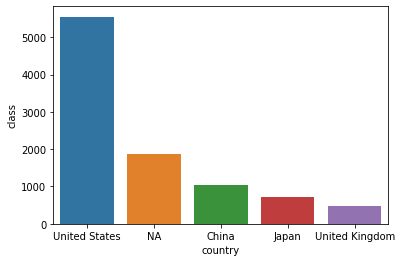

In [5]:
grouped = Fraud_data[['country','class']].groupby('country').sum().reset_index().sort_values(by='class',ascending=False)
sns.barplot(x='country',y='class',data=grouped[:5])

### Feature Engineering

In [6]:
# Get the time difference between purchase time and signup time
time_diff = Fraud_data['purchase_time'] - Fraud_data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
Fraud_data['time_diff'] = time_diff

In [7]:
# Check user number for unique devices
device_num = Fraud_data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
Fraud_data = Fraud_data.merge(device_num, how='left', on='device_id')

In [8]:
Fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


### Split test and train data

In [9]:
data = Fraud_data[['purchase_value','source','browser','sex','age','class','country','time_diff','device_num']]

In [10]:
test = pd.get_dummies(data)

In [11]:
Y = test['class'].copy()
X = test.copy().drop('class',axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size = 0.2,random_state = 2000)

### XGBoost

In [48]:
# estimator = XGBClassifier(
#     objective= 'binary:logistic',
#     nthread=4,
#     seed=42
# )

# param_grid = {
#     'n_estimators': [400, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20],
#     'reg_alpha': [1.1, 1.2],
#     'reg_lambda': [1.1, 1.2],
#     'subsample': [0.7, 0.8]
# }

# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     scoring = 'roc_auc',
#     n_jobs = 5,
#     cv = 5,
#     verbose=True
# )

In [49]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
y_pre = model.predict(X_test)
y_exam = model.predict(X_train)

In [51]:
def print_metric(X_train, X_test, y_train, y_test, estimator):
    print('In sample R-squared: ', r2_score(y_train, estimator.predict(X_train)))
    print('Out of sample R-squared: ', r2_score(y_test, estimator.predict(X_test)))
    print('In sample MSE: ', mean_squared_error(y_train, estimator.predict(X_train)))
    print('Out of sample MSE: ', mean_squared_error(y_test, estimator.predict(X_test)))

In [52]:
print(classification_report(y_true=y_test, y_pred=(y_pre > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27427
           1       1.00      0.54      0.70      2796

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



In [53]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_exam)
test_fpr, test_tpr, _ = roc_curve(y_test, y_pre)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

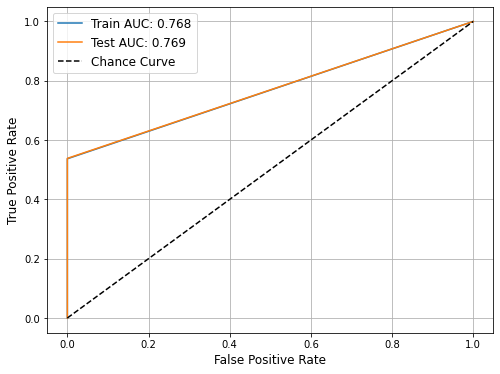

In [54]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

### Random Forest

In [13]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
y_pre = clf.predict(X_test)

In [16]:
y_insmaple = clf.predict(X_train)

In [17]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_insmaple)
test_fpr, test_tpr, _ = roc_curve(y_test, y_pre)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

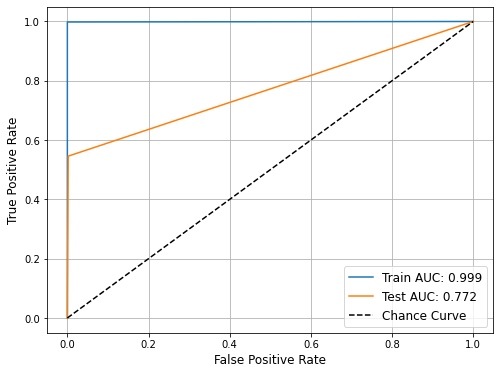

In [18]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

### Insights

In [24]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(clf, X_train, y_train, r2)
perm_imp_rfpimp = pd.DataFrame(perm_imp_rfpimp.Importance)

In [56]:
perm_imp_rfpimp = pd.DataFrame(perm_imp_rfpimp.Importance)

In [79]:
pd.DataFrame(perm_imp_rfpimp[:10])

,Importance
Feature,
time_diff,1.449798
age,0.462394
purchase_value,0.445536
browser_Chrome,0.250463
device_num,0.245647
country_United States,0.228789
source_Ads,0.214339
sex_M,0.211931
source_SEO,0.199889
